# Powerlifting Performance Analysis: A Data Science Approach

# Fall 2024 Data Science Project
#### By: David Liu and Andrew Xie

# **Contributions**
David Liu's Contributions: Worked on proposing the project idea and propositions for data exploration (A), preprocessing and cleaning the dataset (B), conducting data exploration (histogram of weights, nation boxplot analysis, histogram between countries) (C), both machine learning models and visualization (D, E, F), and assisted with compiling final tutorial (G)

Andrew Xie’s Contributions: Worked on proposing the project idea (A), curating and preprocessing the dataset (B), conducting data exploration and summary statistics (C), creating visualizations and analyzing results to draw conclusions (F), and compiling the final tutorial report (G).

# **Introduction**


Powerlifting is a strength sport that tests athletes' abilities in three fundamental lifts: the squat, bench press, and deadlift. While the goal is simple - lift the most weight possible - the factors contributing to success are complex.

Using the OpenPowerlifting dataset, which contains over 1.4 million competition entries from athletes worldwide, we aim to analyze and understand the patterns that define success in this sport. Our analysis focuses on several key questions:

1. What is the relationship between a lifter's body weight and their total weight lifted?
2. How do different countries compare in terms of powerlifting performance?
3. What factors most significantly influence a powerlifter's total competition performance?
4. Can we predict a lifter's strength in certain lifts from a different lift?

Our initial data exploration has revealed intriguing patterns, including:
- Strong correlations between different lifts
- Significant variations in performance across countries
- Distinct bimodal distributions in certain countries' performance data

We will walk through our complete data science pipeline, from data preprocessing to advanced statistical analysis and machine learning applications. We'll demonstrate how data science techniques can provide valuable insights into athletic performance and potentially influence training approaches.

Whether you're a data scientist interested in sports analytics or a powerlifting enthusiast curious about the numbers behind the sport, this analysis offers practical insights into the factors that shape success in competitive powerlifting.

# **Data Collection**

#### Data Source
Our analysis utilizes the OpenPowerlifting dataset, a comprehensive collection of powerlifting competition results. This dataset is publicly available and regularly updated, containing competition records from various federations worldwide. We accessed the data through [OpenPowerlifting.org](https://www.openpowerlifting.org/), downloading it as a CSV file containing over 1.4 million entries.

#### Initial Data Overview
The raw dataset included 37 columns with various metrics and competition details. For our analysis, we focused on the most relevant features:



In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Import the dataset
df = pd.read_csv("openpowerlifting.csv", low_memory=False)

# Select relevant columns
df = df[['Name', 'Sex', 'Age', 'BodyweightKg', 'Best3SquatKg',
         'Best3BenchKg', 'Best3DeadliftKg', 'TotalKg', 'Tested',
         'Country', 'Date', 'MeetCountry']]

# Data Curation

After reviewing all available features, we selected 12 key columns most relevant to our analysis:

- **Name**: Competitor's full name  
- **Sex**: Gender of competitor (M/F)  
- **Age**: Competitor's age at time of competition  
- **BodyweightKg**: Recorded body weight in kilograms  
- **Best3SquatKg**: Highest successful squat attempt  
- **Best3BenchKg**: Highest successful bench press attempt  
- **Best3DeadliftKg**: Highest successful deadlift attempt  
- **TotalKg**: Combined weight of all successful lifts  
- **Tested**: Drug testing status  
- **Country**: Competitor's country of origin  
- **Date**: Competition date  
- **MeetCountry**: Host country of competition

# Data Quality Assessment and Cleaning

In this spreadsheet, failed lifts are the negative of the attempted weight. Thus, if a lifter fails all three of a specific lift, their "Best3LiftKg" category will be negative. We must clean to remove these from our data. Because the proportion of lifters that fail all three lifts is not significant, we can just remove these entries altogether.


In [ ]:
df = df[
    (df['Best3SquatKg'] >= 0) &
    (df['Best3BenchKg'] >= 0) &
    (df['Best3DeadliftKg'] >= 0)
]

# Data Exploration

Lets identify correlations between BodyweightKg, TotalKg, Best3SquatKg, Best3DeadliftKg to find variables with significant influence on each other.

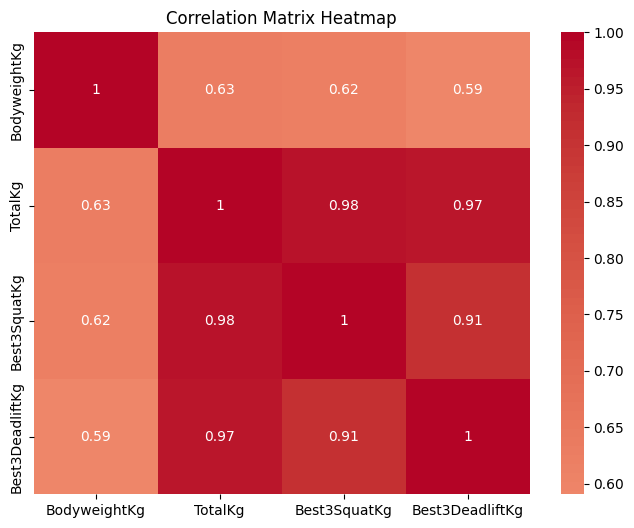

In [ ]:
# compute correlation matrix
corr_matrix = df[['BodyweightKg', 'TotalKg', 'Best3SquatKg', 'Best3DeadliftKg']].corr()

# plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix Heatmap')
plt.show()

**TotalKg and Best3SquatKg (0.98):** <br>
Strong positive correlation: A high squat performance is closely associated with a higher total weight lifted. This is expected, as the squat is a vital component of the total lift.

**TotalKg and Best3DeadliftKg (0.97):** <br>
High positive correlation: Deadlift performance contributes significantly to the total weight lifted. However, the correlation is slightly lower than that of squats, suggesting that deadlift results might vary more across participants relative to their total lift performance.

**Best3SquatKg and Best3DeadliftKg (0.91):** <br>
Strong positive correlation: Strong squat performance is highly indicative of a strong deadlift, which makes sense as both are compound lower body exercises engaging similar muscle groups.

**Conclusion:**

*   Total weight lifted (TotalKg) is most strongly influenced by the squat.
*   Bodyweight plays a role in performance but isn’t the sole determinant of lifting success.
*   There are high correlations between key lifts, indicating that lifters who excel in one movement tend to perform well in others.



**Lets test for outliers in TotalKg: the total weight moved throughout all three lifts by each competitor.**

H0: There are no significant outliers in TotalKg.
Ha: There are significant outliers in TotalKg.

Method 1: Use Z-score to identify extreme outliers Method 2: Use boxplot fences to identify extreme outliers

Plot: Boxplot

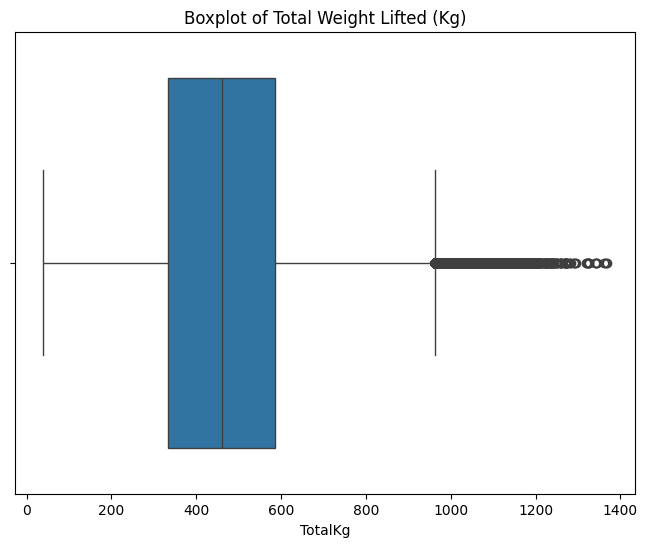

Z-Score Outliers detected: 0 entries
IQR-based Outliers detected: 5125 entries


In [ ]:
df = df.copy()
df['Z_TotalKg'] = stats.zscore(df['TotalKg'])

# identify outliers (Z-score > 2 or < -2)
outliers = df.loc[df['Z_TotalKg'].abs() > 2]

plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='TotalKg')
plt.title('Boxplot of Total Weight Lifted (Kg)')
plt.show()


print(f"Z-Score Outliers detected: {len(outliers)} entries")

# identify outliers (IQR)
Q1 = df['TotalKg'].quantile(0.25)
Q3 = df['TotalKg'].quantile(0.75)
IQR = Q3 - Q1

lower_bound, upper_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

iqr_outliers = df[(df['TotalKg'] < lower_bound) | (df['TotalKg'] > upper_bound)]

print(f"IQR-based Outliers detected: {len(iqr_outliers)} entries")
# iqr_outliers

Using the z-score method for finding outliers, in which any point with a z-score greater than 2 or less than -2 is marked an outlier, we don't find any outliers.

Using the fences from out boxplot, which mark any point outside the fences of the boxplot as an outlier, we find 5125 outliers. Boxplot fences are generated by adding 1.5 * IQR to the upper quartile and subtracting 1.5 * IQR from the lower quartile.

All outliers found are upper outliers, meaning that they are all greater than upper quartile + 1.5 * IQR. There are no low outliers.

So what do we do with these outliers? Well... nothing! These outliers represent that there are certain individuals that are significantly stronger than the average competitor, and their presence is not negligable. While for certain test, removing them may prove useful, we cannot simply remove them as they help uncover truths in our analysis in the future!

Lets follow up on this data exploration! Because all of our found outliers were high outliers, this implies that our data is right skewed. Lets make a histogram of our values to see if this holds true.

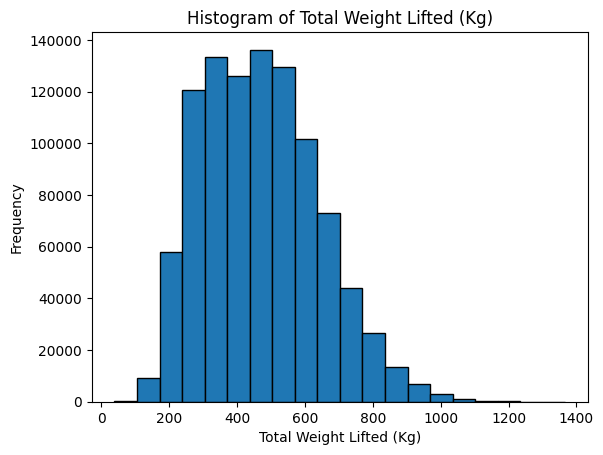

In [ ]:
plt.hist(df['TotalKg'], bins=20, edgecolor='black')
plt.title('Histogram of Total Weight Lifted (Kg)')
plt.xlabel('Total Weight Lifted (Kg)')
plt.ylabel('Frequency')
plt.show()

Fascinating! The right tail of our data is slightly stretched and the data does appear slightly right skewed, which we predicted. Otherwise, the data looks approximately normal.

**Lets explore whether certain countries have different distributions of their TotalKg, the total amount of weight moved in all three lifts.**

Lets set up our hypothesis test!

HO: The country of a competitor does not have an effect on the total weight that they lift in the competition.
HA: The country of a competitor does have an effect on the total weight that they lift in the competition.
Now lets get coding! Lets first filter out countries that have less than a certain number of competitors. Then, lets run an ANOVA test to see if any country has a statistically significant mean than that of other countries.

NOTE: By conducting an ANOVA test, we are assume that the data for each group (country in our case) is normal and their standard deviations are around the same.




In [ ]:
min_entries = 5000
filtered_df = df.groupby('Country').filter(lambda x: len(x) >= min_entries)
filtered_df = filtered_df.dropna(subset=['TotalKg'])

group_sizes = filtered_df.groupby('Country').size()
print("Group sizes:\n", group_sizes)

groups = [group['TotalKg'].values for name, group in filtered_df.groupby('Country')]

f_stat, p_val = stats.f_oneway(*groups)
print(f"F-statistic: {f_stat}, p-value: {p_val}")

Group sizes:
 Country
Australia    12553
Canada        9500
Czechia       7977
Finland      11086
Germany       6396
Norway        8224
Russia       17638
Sweden        5864
UK           10783
USA          52532
Ukraine      10915
dtype: int64
F-statistic: 167.92123566439025, p-value: 0.0


Note that we filtered for countries with more than 10000 competitors, and then removed the NaN values in totalKg for each group.

Out p-value from our test is astoundingly low (~0.0 - less than any sensible confidence level we might use). This means that we can reject the null hypothesis, meaning that there is at least one group in our with a different mean than the other groups and that the country of a competitor has an impact on their total weight lifted.

Why dont we visualize this by plotting each group as a box plot and then comparing them!

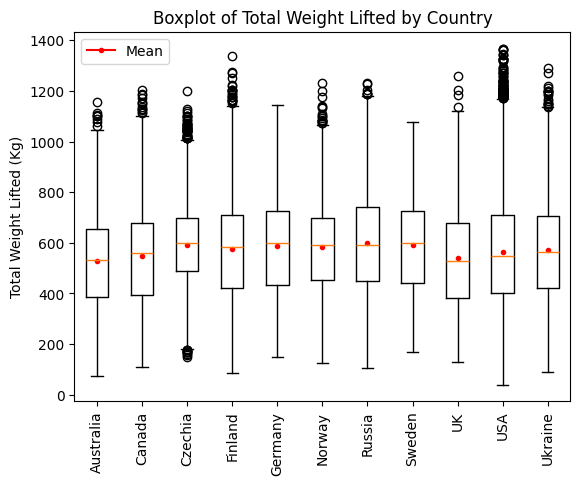

In [ ]:
plt.boxplot([*groups], labels=group_sizes.index)

means = []
for group in groups:
    means.append(group.mean())

for i, mean in enumerate(means):
    plt.plot(i + 1, mean, marker=".", color='red', label='Mean' if i == 0 else "")  # Plot the mean

plt.title('Boxplot of Total Weight Lifted by Country')
plt.ylabel('Total Weight Lifted (Kg)')
plt.xticks(rotation=90)
plt.legend()
plt.show()

Viewing out boxplots, we notice a couple trends. Some countries appear to have a slightly different distribution than others. Lets compare Canada and Russia. Russia's upper and lower quartiles appear to be fairly lower than Canada's. What's more interesting is that Russia's median sits significantly lower within the interquartile than Canada's. To examine this a bit further, why dont we plot the histograms of Canada and Russia's TotalKg on each other.

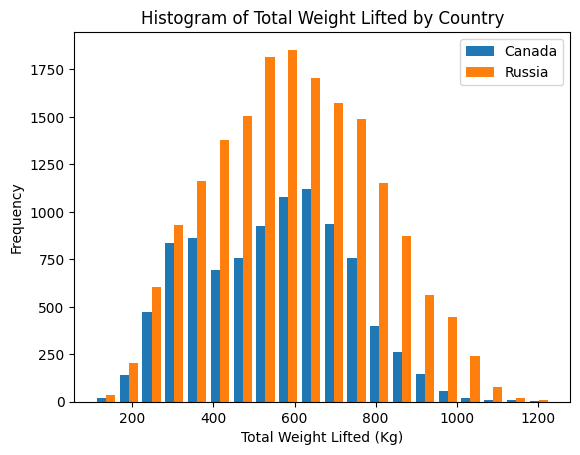

In [ ]:
canada_data = filtered_df[filtered_df['Country'] == 'Canada']['TotalKg']
russia_data = filtered_df[filtered_df['Country'] == 'Russia']['TotalKg']

plt.hist([canada_data, russia_data], bins = 20, label=['Canada', 'Russia'])
plt.legend()
plt.title('Histogram of Total Weight Lifted by Country')
plt.xlabel('Total Weight Lifted (Kg)')
plt.ylabel('Frequency')
plt.show()

**WAIT!**

We have a lot more data on lifters from Russia than from Canada, so why don't we try plotting the frequencies of these countries instead of just flat values!

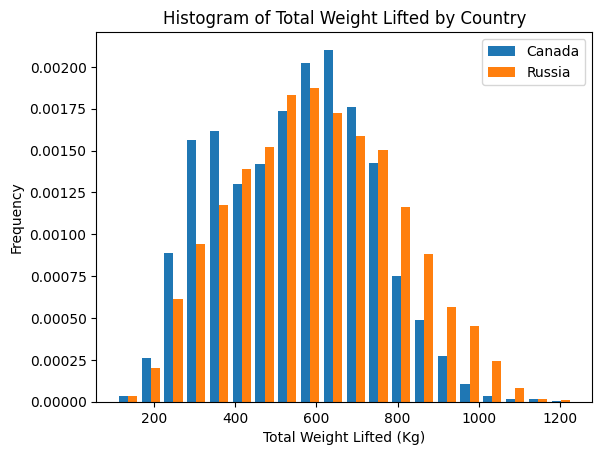

In [ ]:
canada_data = filtered_df[filtered_df['Country'] == 'Canada']['TotalKg']
russia_data = filtered_df[filtered_df['Country'] == 'Russia']['TotalKg']

plt.hist([canada_data, russia_data], bins = 20, density=True, label=['Canada', 'Russia'])
plt.legend()
plt.title('Histogram of Total Weight Lifted by Country')
plt.xlabel('Total Weight Lifted (Kg)')
plt.ylabel('Frequency')
plt.show()

Interesting... looks pretty similar, though Canada appears to have a spike in concentration of lifters who's total lift amounts to around 300kg. Canada also appears to have a higher concentration of lifters around it's mode of around 600kg.

# Primary Analysis

In our primary step of our data exploration, we notice that Best3SquatKg and Best3DeadliftKg have a pretty strong correlation coefficient. This indicates that we might be able to use a machine learning algorithm like a linear regression model to be able to predict one from the other.

Why do this? Perhaps some lifters aren't (for whatever reason) able to complete their squat lift, but were able to complete their deadlift. Or maybe a careless engineer lost some data regarding the squat weights of lifters. In these cases, we may be able to predict those values using a linear regression model. Lets try it!

Lets train our model to predict a lifter's squat based on their deadlift.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

def fit_model(X_train, Y_train):
    model = LinearRegression()
    model.fit(X_train, Y_train)
    return model

def predict_data(model, X_train, X_test):
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)
    return Y_train_pred, Y_test_pred

def split_data(X, Y, test_size=0.25, random_state=10):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)
    return X_train, X_test, Y_train, Y_test

X_train, X_test, Y_train, Y_test = split_data(df["Best3SquatKg"], df["Best3DeadliftKg"])

Before we train out model, lets go ahead and visualize our data!

Lets plot our data to see our split between training and testing data for squat and deadlift!

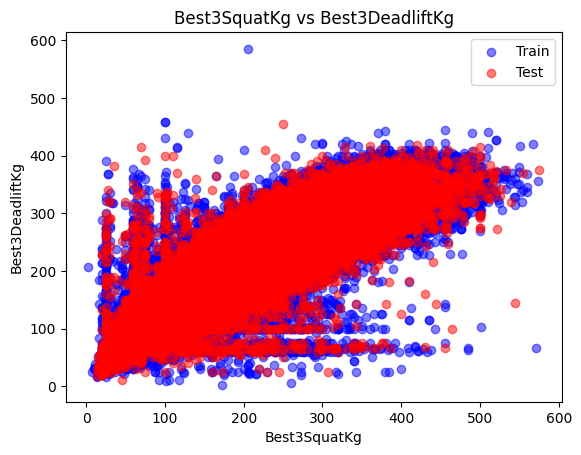

In [ ]:
plt.scatter(X_train, Y_train, color='blue', label='Train', alpha=0.5)
plt.scatter(X_test, Y_test, color='red', label='Test', alpha=0.5)
plt.title("Best3SquatKg vs Best3DeadliftKg")
plt.xlabel("Best3SquatKg")
plt.ylabel("Best3DeadliftKg")
plt.legend()
plt.show()

Wow I can't see anything at all. Lets just display like 0.1% of all data entries. (This is just for data visualization by the way, we will train using all 100% of our train set)

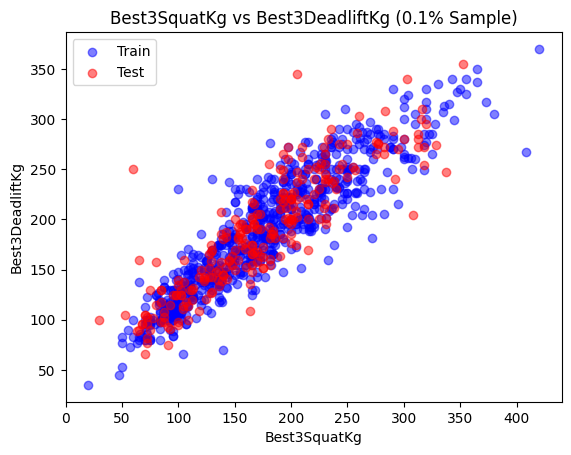

In [ ]:
frac = 0.001
X_train_sample = X_train.sample(frac=frac, random_state=10)
Y_train_sample = Y_train.sample(frac=frac, random_state=10)
X_test_sample = X_test.sample(frac=frac, random_state=10)
Y_test_sample = Y_test.sample(frac=frac, random_state=10)

# Scatter plot with 1% of data
plt.scatter(X_train_sample, Y_train_sample, color='blue', label='Train', alpha=0.5)
plt.scatter(X_test_sample, Y_test_sample, color='red', label='Test', alpha=0.5)
plt.title("Best3SquatKg vs Best3DeadliftKg (0.1% Sample)")
plt.xlabel("Best3SquatKg")
plt.ylabel("Best3DeadliftKg")
plt.legend()
plt.show()

Much better... Now, lets get to training our linear regression model.

In [ ]:
model = fit_model(X_train.values.reshape(-1, 1), Y_train)
Y_train_pred, Y_test_pred = predict_data(model, X_train.values.reshape(-1, 1), X_test.values.reshape(-1, 1))

Alright, now lets plot the regression line along with a sample of our data.

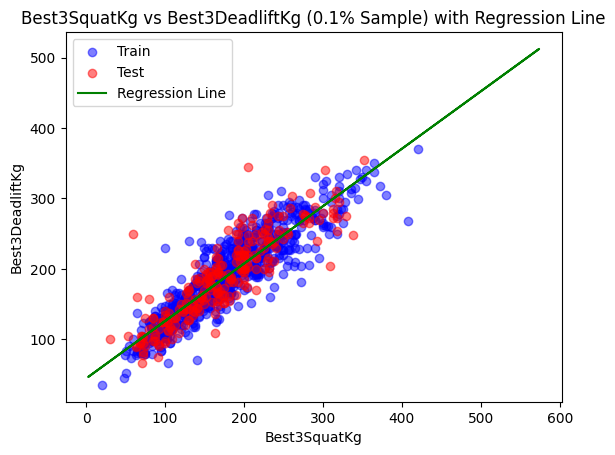

In [ ]:
plt.scatter(X_train_sample, Y_train_sample, color='blue', label='Train', alpha=0.5)
plt.scatter(X_test_sample, Y_test_sample, color='red', label='Test', alpha=0.5)
plt.plot(X_train, Y_train_pred, color='green', label='Regression Line')
plt.title("Best3SquatKg vs Best3DeadliftKg (0.1% Sample) with Regression Line")
plt.xlabel("Best3SquatKg")
plt.ylabel("Best3DeadliftKg")
plt.legend()
plt.show()

Looking good, looks like we can predict the data pretty well! But we want to actually quantify and evaluate how our model performs! To do this, lets check the MSE (Mean Squared Error) and r^2 values of our model when it comes to the testing data.

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
mse_test = mean_squared_error(Y_test, Y_test_pred)
print(f"MSE on Test Data: {mse_test}")
r2_test = r2_score(Y_test, Y_test_pred)
print(f"R^2 on Test Data: {r2_test}")

MSE on Test Data: 660.4814629994559
R^2 on Test Data: 0.8214031880786246


Looks like our MSE is pretty high, but that's pretty natural. At the end of the day, there will always be a large portion of lifters that are significantly stronger at deadlift relative to their squat (and vice versa), making it hard to predict one from the other.

However, looking at our r^2 value, it actually looks quite strong! This indicates that 82% of the variation in our dependent variable (deadlift weights) is predicted by model (using squat weights). An r^2 value of 0.82, which range from 0 to 1, is quite strong and indicates that our model is pretty good at explaining variation in the dependent variable!

Ok a linear model is pretty cool, but it's only based on one variable, and may not be super useful in identifying context that can be gathered from other indicators. Are you thinking what I'm thinking? Lets build a neural network!

Let's try and predict a lifter's weight based on sex, age, squat, bench, deadlift. For sex, we'll use onehot encoding!

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class MLPModel(nn.Module):
    def __init__(self, feat_dim):
        super(MLPModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(feat_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
# One hot encoding
df_nn = pd.get_dummies(df, columns=['Sex'])
df_nn["Sex_M"] = df_nn["Sex_M"].astype(int)
df_nn["Sex_F"] = df_nn["Sex_F"].astype(int)
df_nn = df_nn.dropna()
df_y = df_nn.copy()
df_nn = df_nn.drop(columns=['Name', 'Country', 'MeetCountry', 'Tested', 'Date', 'BodyweightKg'])

X_train, X_test, y_train, y_test = train_test_split(df_nn, df_y["BodyweightKg"], test_size=0.2)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.values)
X_test = scaler.transform(X_test.values)

# Tensorize!!
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Feature dimension
feat_dim = X_train.shape[1]

print("Feature dimension:", feat_dim)
print("Features should be sex (male or female, 2), age, squat, bench, deadlift, totalkg")

Feature dimension: 7
Features should be sex (male or female, 2), age, squat, bench, deadlift, totalkg


In [ ]:
nn_model = MLPModel(feat_dim=feat_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(nn_model.parameters(), lr=0.0001)


epochs = 30
losses = []
for epoch in range(epochs):
    running_loss = 0.0
    for batch_idx, (data, targets) in enumerate(train_loader):
        outputs = nn_model(data)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    losses.append(loss.item())
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

print('Finished Training')

Epoch 1/30, Loss: 1127.21044921875
Epoch 2/30, Loss: 323.44921875
Epoch 3/30, Loss: 116.99822235107422
Epoch 4/30, Loss: 175.23764038085938
Epoch 5/30, Loss: 192.7774658203125
Epoch 6/30, Loss: 157.8203125
Epoch 7/30, Loss: 251.70457458496094
Epoch 8/30, Loss: 137.09776306152344
Epoch 9/30, Loss: 218.39195251464844
Epoch 10/30, Loss: 114.06483459472656
Epoch 11/30, Loss: 326.7974548339844
Epoch 12/30, Loss: 157.32394409179688
Epoch 13/30, Loss: 205.046630859375
Epoch 14/30, Loss: 398.9728088378906
Epoch 15/30, Loss: 234.05865478515625
Epoch 16/30, Loss: 174.32859802246094
Epoch 17/30, Loss: 213.07357788085938
Epoch 18/30, Loss: 342.23797607421875
Epoch 19/30, Loss: 102.7017822265625
Epoch 20/30, Loss: 241.019775390625
Epoch 21/30, Loss: 280.50091552734375
Epoch 22/30, Loss: 277.4296875
Epoch 23/30, Loss: 173.2089080810547
Epoch 24/30, Loss: 222.09242248535156
Epoch 25/30, Loss: 135.603271484375
Epoch 26/30, Loss: 187.31448364257812
Epoch 27/30, Loss: 414.76446533203125
Epoch 28/30, Los

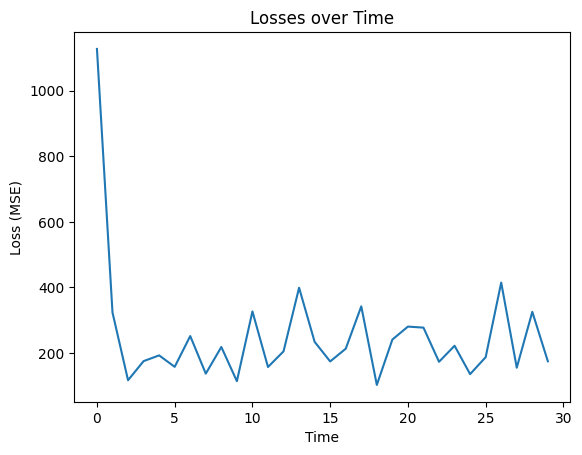

Test Loss: 258.5055752063126


In [ ]:
plt.plot(losses)
plt.title("Losses over Time")
plt.xlabel("Time")
plt.ylabel("Loss (MSE)")
plt.show()

test_loss = 0.0
for batch_idx, (data, targets) in enumerate(test_loader):
    loss = criterion(nn_model(data), targets)
    test_loss += loss.item()
test_loss = test_loss / len(test_loader)
print(f'Test Loss: {test_loss}')

Yea... it's not great. But that's the thing about using real world data and also a small limited set of features that may or may not describe the target variable very well. We still saw loss go down drastically from our initial untrained (randomly initialized) model, so it at least predicts somewhat. If we had more data and more features that were describing of our target variable (lifter's weight), then perhaps we would've seen a lower loss, but this isn't terrible.

# **Insights and Conclusions**

### **Key Findings**

#### 1. Lift Correlations and Performance Relationships
- Strong positive correlations exist between different lifts, with squat showing the highest correlation (0.98) with total weight lifted
- Deadlift performance also strongly correlates (0.97) with total weight, suggesting these compound movements are crucial indicators of overall strength
- The high correlation (0.91) between squat and deadlift performance indicates that strength in one lift typically translates to strength in the other

#### 2. Geographic Performance Variations
- Statistical analysis revealed significant differences in performance across countries (p-value ≈ 0.0)
- Notable variations were observed between countries like Canada and Russia, with distinct distribution patterns in their total weight lifted
- Some countries showed unique bimodal distributions, suggesting potential differences in training methodologies or competitor populations

#### 3. Predictive Modeling Insights
- Linear regression model showed strong predictive power (R² = 0.82) for estimating deadlift performance based on squat numbers
- The neural network model for bodyweight prediction showed limited success, highlighting the complexity of predicting physiological characteristics from performance data
- The high MSE in predictions suggests significant individual variation in lifting patterns that can't be explained by simple linear relationships

#### 4. Data Quality and Distribution
- The dataset showed right-skewed distribution in total weight lifted, indicating the presence of elite performers
- 5,125 upper outliers were identified, representing exceptionally strong athletes rather than data errors
- The presence of these statistical outliers provides valuable insights into the range of human performance in the sport

### **Practical Applications**

#### 1. Training Program Design
- The strong correlations between lifts suggest that focusing on improving one compound movement likely benefits overall strength
- Coaches can use these relationships to make informed decisions about training emphasis and program design

#### 2. Competition Strategy
- The predictive models could help estimate potential performance in different lifts, useful for attempt selection in competition
- Understanding the relationship between body weight and performance can aid in weight class selection

#### 3. Weight Substitution
- Both models can be used to fill in data that may be lost or not recorded
- For example, if a lifter's weight is not recorded, but all other parameters needed for our neural network are recorded, the model can predictively suggest a lifter's weight for substitution

### **Limitations and Future Research**

#### 1. Data Constraints
- The analysis focused primarily on successful lifts, potentially missing insights from failed attempts
- Limited demographic data restricts deeper understanding of factors like training experience and background

#### 2. Model Improvements
- Future research could incorporate more variables like training history and competition experience
- More sophisticated machine learning approaches might yield better predictive results

#### 3. Temporal Analysis
- A longitudinal study of performance trends over time could provide valuable insights into sport development
- Analysis of how performance patterns change with age and experience could benefit long-term athlete development

---

This analysis provides valuable insights for both practitioners and researchers in the field of strength sports, while highlighting areas for future investigation. The findings contribute to our understanding of powerlifting performance factors and can inform evidence-based approaches to training and competition preparation.
